# YNet - Dataset 4:

Data from Experiment (2), Mitochondria = Cit1-mCherry 

### Importing utilities:

In [149]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [44]:
PATH = "datasets/yeast_v4.2/"
data_path = Path(PATH)

In [45]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

#### Calculating normalization statistics

In [46]:
stats_name = "yeast_v4.2_per_class.dict"
classes = Statistics.source_class(data_path)

train_val = zip(classes['train'], classes['val'])
Xtest = zip(classes['test'])
 
main_stats = Statistics.per_class(train_val, save_name=stats_name)
test_stats = Statistics.per_class(Xtest, save_name=stats_name)

working on: Cit1_MC_mfb1KO
working on: Cit1_MC_mfb1KO
working on: Cit1_MC_mfb1KO_mmr1KO
working on: Cit1_MC_mfb1KO_mmr1KO
working on: Cit1_MC_mmr1KO
working on: Cit1_MC_mmr1KO
working on: Cit1_MC_WT
working on: Cit1_MC_WT
working on: Cit1_MC_mfb1KO
working on: Cit1_MC_mmr1KO


In [135]:
for keys in main_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

Cit1_MC_mfb1KO: 	 	 	 (array([0.00795, 0.00474]), array([0.00072, 0.00158]))
Cit1_MC_mfb1KO_mmr1KO: 	 	 	 (array([0.00789, 0.00471]), array([0.00072, 0.00152]))
Cit1_MC_mmr1KO: 	 	 	 (array([0.008  , 0.00472]), array([0.00075, 0.0016 ]))
Cit1_MC_WT: 	 	 	 (array([0.00797, 0.00483]), array([0.00076, 0.00153]))


## Defining datasets:

In [137]:
def tfms_for_test(stats, sz):
    test_norm = Normalize(stats)
    test_denorm = Denormalize(stats)
    val_crop = CropType.NO
    test_tfms = image_gen(test_norm, test_denorm,sz, crop_type=val_crop)
    return test_tfms

In [139]:
def get_data(path: str, sz, bs):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='val', test_name='test', test_with_labels=True, bs=bs)
    main_stats_X = {lbl2index[key]: val for key, val in main_stats.items()}
    test_stats_X= {lbl2index[key]: val for key, val in test_stats.items()}
    tfms = tfms_from_stats(main_stats_X, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    test_tfms = tfms_for_test(test_stats_X,sz)
    tfms += (test_tfms, )
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [140]:
data = get_data(PATH,SIZE, BATCH_SIZE)


 class to index mapping:
 {'Cit1_MC_WT': 0, 'Cit1_MC_mfb1KO': 1, 'Cit1_MC_mfb1KO_mmr1KO': 2, 'Cit1_MC_mmr1KO': 3}


In [141]:
x, y = next(iter(data.trn_dl))

### Inspect loaded data:

C:\Anaconda3\envs\fastai\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))
C:\Anaconda3\envs\fastai\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Anaconda3\envs\fastai\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))


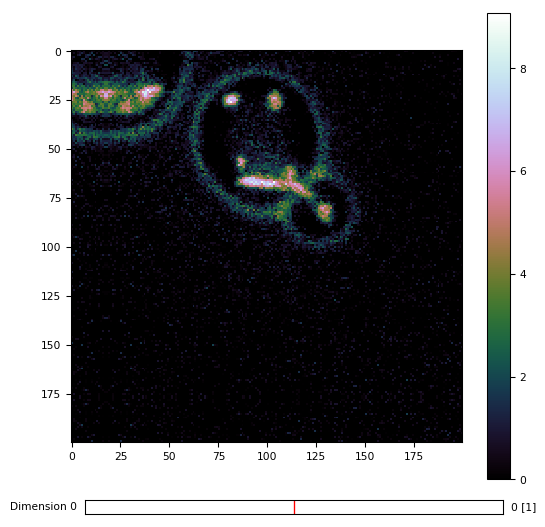

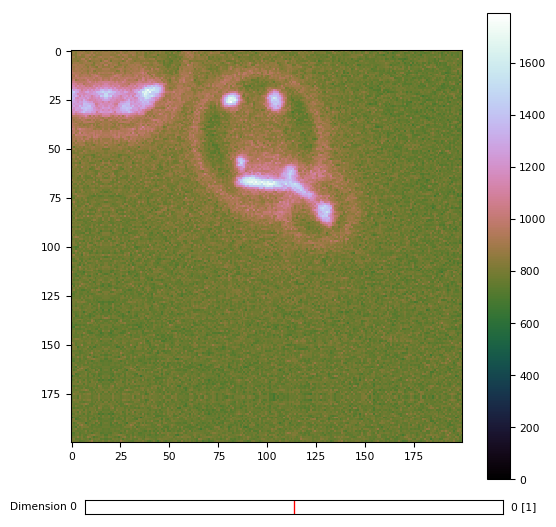

In [183]:
# specify which image-index
idx = 60

# loading it from GPU to CPU
xx = x[idx].cpu().numpy().copy()
yy = y[idx]
# showing the image
#
#sp.axis('Off')
#sp.set_title("Norm", fontsize=11)
figure, _ ,_ = tiff.imshow(np.sum(xx, axis=0))
figure.set_size_inches(6,6)
figure.add_subplot(111)

figure2, _, _ = tiff.imshow(np.sum(data.trn_ds.denorm(xx,yy).squeeze() * 65536, axis=2))
figure2.set_size_inches(6,6)


# Training setup

In [62]:
torch.cuda.is_available()

True

## ResNet_with_Batchnorm

In [184]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [185]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [188]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [195]:
wd=1e-5

In [196]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 4), data)

In [191]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [197]:
%time learn.fit(1e-2, 8, cycle_len=1, wds=wd)

EPOCH 0 ---------------------------------------- STEP 1                                                                                                                                                              
mean: [26.22222 25.22222 12.      34.66667]
stdev: [6.92464 6.77869 4.      4.2947 ]

[Cit1_MC_WT]: 100.0%
[Cit1_MC_mfb1KO]:  0.0%
[Cit1_MC_mfb1KO_mmr1KO]:  0.0%
[Cit1_MC_mmr1KO]:  0.0%
epoch      trn_loss   val_loss   accuracy   
    0      32.706517  66.714168  0.25      
EPOCH 1 ---------------------------------------- STEP 2                                                                                                                                                              
mean: [26.44444 25.11111 11.88889 34.44444]
stdev: [3.53117 3.03478 3.31476 3.59355]

[Cit1_MC_WT]:  0.0%
[Cit1_MC_mfb1KO]:  0.0%
[Cit1_MC_mfb1KO_mmr1KO]:  0.0%
[Cit1_MC_mmr1KO]: 100.0%
    1      32.609308  37.506788  0.25      
EPOCH 2 ---------------------------------------- STEP 3            

[array([1.07426]), 0.4714285714285714]

In [ ]:
# at very little overfitting we have 43% accuracy
%time learn.fit(1e-2, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85))

In [ ]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85))

### Show loss over time

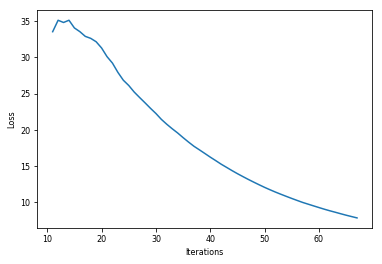

In [205]:
f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

## Analysis

### ...after training 

In [211]:
## Load model:
learn.load('Objective_A_Resnet_per_class_2')

In [215]:
%time learn.fit(1e-10, 1, wds=wd, cycle_len=1)

EPOCH 0 ---------------------------------------- STEP 10                                                                                                                                                             
mean: [26.44444 25.22222 12.      34.77778]
stdev: [3.37017 7.25378 2.98142 5.80762]

[Cit1_MC_WT]: 88.57%
[Cit1_MC_mfb1KO]: 80.0%
[Cit1_MC_mfb1KO_mmr1KO]: 48.57%
[Cit1_MC_mmr1KO]: 68.57%
epoch      trn_loss   val_loss   accuracy   
    0      0.430629   0.656937   0.714286  

Wall time: 6.67 s


[array([0.65694]), 0.7142857125827244]

In [213]:
log_preds, y = learn.TTA() # run predictions with TTA

### Confusion matrix

[[33  0  5  1]
 [ 1 30  7  4]
 [ 0  5 14  6]
 [ 1  0  9 24]]


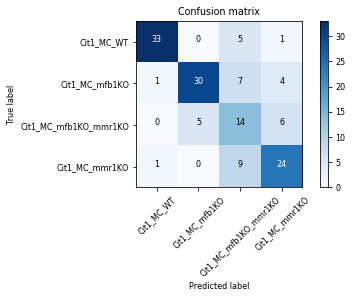

In [214]:
# Plot confusion matrix 
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)

### Analyse images 

#### Show random correct/incorrectly classified images:

In [216]:
log_preds_mean = np.mean(log_preds, axis=0) # averages predictions on original + 4 TTA images
preds = np.argmax(log_preds_mean, axis=1) # converts into 0 or 1

In [217]:
# probs = np.exp(log_preds_mean[:,0]) # prediction(WT)
probs = np.exp(log_preds_mean) # predictions

In [218]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [219]:
def plots(ims, channel, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=11)
        if channel is not None: plt.imshow(ims[i,channel,:,:]) 
        else: plt.imshow(np.sum(ims, axis=1)[i,:,:])

In [220]:
def plot_val_with_title_from_ds_no_denorm(idxs, title, channel=None):
    
    imgs = np.stack(data.val_ds[x][0] for x in idxs) # get images by idx
    corr_lbl = np.stack(data.val_ds[x][1] for x in idxs) # get correct label from data.val_ds by idx
    pred_lbl = np.stack(preds[x] for x in idxs) # get predicted label from preds by idx
    p_max = [np.amax(probs[x,:]) for x in idxs] # get highes probability from probs by idx
    
    title_fin = [f"true = {corr_lbl[x]}\n predicted: {pred_lbl[x]}\n  p = {p_max[x]}" for x in corr_lbl]
    print(title)
    
    return plots(imgs, channel, rows=1, titles=title_fin, figsize=(16,8))

### Plot images according to predictions

Correctly classified


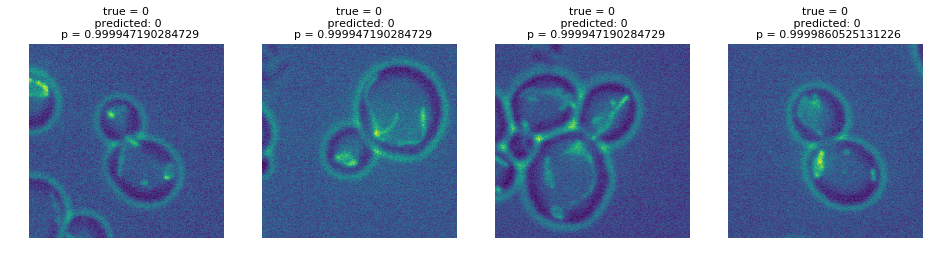

In [221]:
# load from ds - not denormalized! 
plot_val_with_title_from_ds_no_denorm(rand_by_correct(True), "Correctly classified")
#optionally pass channel arg. to select single channel

Incorrectly classified


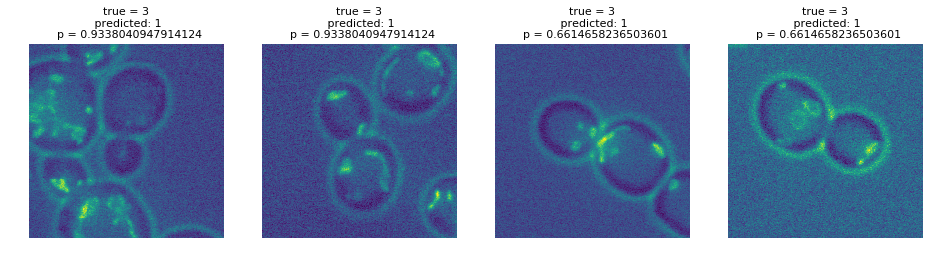

In [222]:
plot_val_with_title_from_ds_no_denorm(rand_by_correct(False), "Incorrectly classified")

#### Show most correct/incorrectly classified images per class:

In [223]:
def most_by_mask(mask, y, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[:,y][idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), y, mult)

Most correctly classified WT


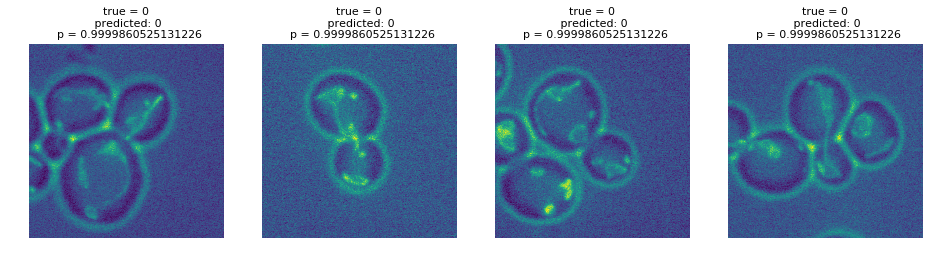

In [224]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, True), "Most correctly classified WT")

Most incorrectly classified WT


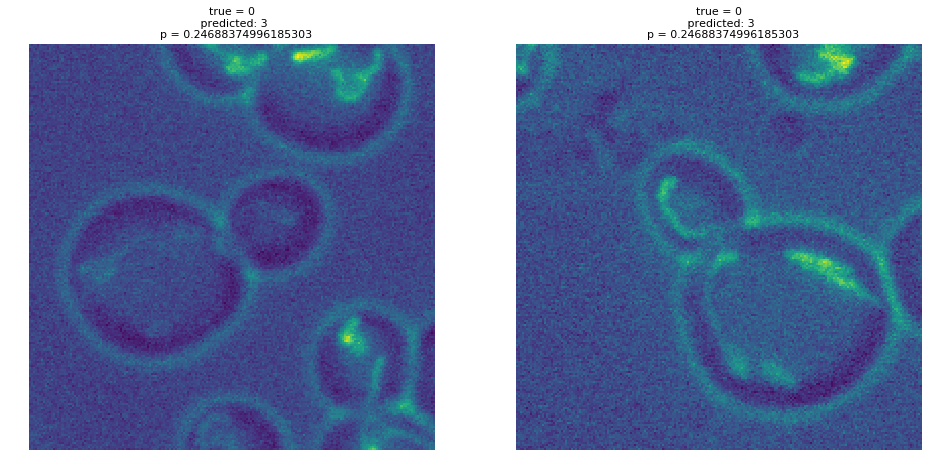

In [225]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(0, False), "Most incorrectly classified WT") # logic?

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, True), "Most correctly classified mfb1KO") 

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(1, False), "Most incorrectly classified mfb1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(2, True), "Most correctly classified mfb1KO-mmr1KO")

In [ ]:
plot_val_with_title_from_ds_no_denorm(most_by_correct(3, True), "Most correctly classified mmr1KO")

In [ ]:
# etc.

#### Show (most) uncertain images

Most uncertain predictions


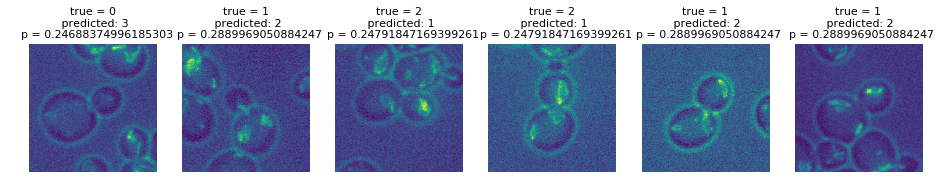

In [226]:
most_uncertain = t = np.argsort(np.amax(probs, axis = 1))[:6] # get best "guess" per image and list the least confident ones
plot_val_with_title_from_ds_no_denorm(most_uncertain, "Most uncertain predictions")

# DOES THE MODEL GENERALIZE?????

In [83]:
learn.load('Objective_A_Resnet_per_class_2')

In [88]:
test_log_preds, targs = learn.predict_with_targs(is_test=True)
testprobs = np.exp(test_log_preds)
preds = np.argmax(testprobs, axis=1)
print(preds)
len()
print(targs)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 2 1 1 1 2 1 2 1 1 1 1 1 0 1 3 3 3 3 3 2 3 2 3 3 3 2 3 3 3 3 3 0 3
 1 3 3 3 3 3 1 0 3 3 3 3 3 2 3 3]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


In [136]:
for keys in test_stats.keys():
    print(f"{keys}: \t \t \t {main_stats[keys]}")

Cit1_MC_mfb1KO: 	 	 	 (array([0.00795, 0.00474]), array([0.00072, 0.00158]))
Cit1_MC_mmr1KO: 	 	 	 (array([0.008  , 0.00472]), array([0.00075, 0.0016 ]))


In [122]:
len(preds) == len(targs)

True

In [120]:
sum(preds == targs) / 70

0.8142857142857143

In [ ]:
stats_dict

In [ ]:
stats_name = "yeast_v4.2_test_per_class.dict"
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs,save_name=stats_name)

In [ ]:
from pathlib import Path
norm_path = Path(path + '/yeast_v3_test_v1')
xstats = {}

for d in norm_path.iterdir():
    class_images = []
    Statistics.mro
    Statistics.read_class(d, class_images)
    mean = np.mean(class_images, axis=(0,2,3)) / 65536
    std = np.std(class_images, axis=(0,2,3)) / 65536
    stats = {d.name: (mean,std)}

In [ ]:
sz =200
path = PATH
bs = 64
create , lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', test_name='yeast_v3_test_v1', test_with_labels=True, bs=bs)
stats_dictX = {lbl2index[key]: val for key, val in stats_dict.items()}
trn_Xtfms, val_Xtfms = tfms_from_stats(stats_dictX, sz, aug_tfms=[RandomDihedral()], pad=sz//8)


fn = PATH+data.test_ds.fnames[1]
im = open_image(fn)
Nor_im = val_Xtfms(im, y=1)
preds = learn.predict_array(Nor_im[0][None])
print(np.argmax(np.exp(preds)))



In [ ]:
data.test_ds.fnames

In [ ]:
tiff.imshow(data.test_ds[1][0][1,:,:])
# np.amax(data.trn_ds[0][0][0,:,:])

In [ ]:
len(y)

In [ ]:
log_preds = learn.predict_with_targs()
log_testpreds = learn.predict_with_targs(is_test=True)

In [ ]:
testprobs = np.exp(log_testpreds[0])
preds = np.argmax(testprobs, axis=1)
print(log_testpreds)
# print(log_testpreds[1])

In [ ]:
testprobs = np.exp(log_testpreds)
# preds = np.argmax(testprobs, axis=1)
testprobs